In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import collections 
import time
from scipy import signal
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [3]:
data_dir = "/workspace/inkyung/Fall Detection/MobiAct_dataset/"

"""
- Participants num - 
sub1 ~ sub67

- Fall Types - 
FOL = Fall Foward from standing, use of hands to dampen fall
FKL = Fall Forward from standing, first impact on knees
BSC = Fall Backward while trying to sit on a chair
SDL = Fall Sidewards from standing, bending legs

- ADL Types -
STD = Standing with subtle movements
WAL = Normal Walking
JOG = Jogging
JUM = Continous jumping
STU = Stairs up(10 stairs)
STN = Stairs down(10 stairs)
SCH = Transition from standing to sitting
SIT = Sitting on chair with subtle movements
CHU = Transition from sitting to standing
CSI = Step in a car
CSO = Step out a car
LYI = Activity taken from the lying period after a fall

- 87 Hz mean sampling frequency for the accelerometer
- 200 Hz mean sampling rate for gyroscope and orientation data
"""
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
adl_types = ['STD', 'WAL', 'JOG', 'JUM', 'STU', 'STN', 'SCH', 'SIT', 'CHU', 'CSI', 'CSO', 'LYI']
person_numlist = list(range(1, 68))
trials = list(range(1, 4))

In [13]:
std_len_list, fall_len_list, lyi_len_list = list(), list(), list()
for person_num in tqdm.notebook.tqdm(person_numlist):
    for fall_type in fall_types:
        for trial in trials:
            try:
                directory = data_dir + fall_type + '_' + str(person_num) + '_' + str(trial) + '_annotated.csv'
                data = pd.read_csv(directory)

                std_length = len(data[data['label']=='STD'])
                fall_length = len(data[data['label']==fall_type])
                lyi_length = len(data[data['label']=='LYI'])
                
                std_len_list.append(std_length)
                fall_len_list.append(fall_length)
                lyi_len_list.append(lyi_length)
                
            except FileNotFoundError:
                print(fall_type, person_num, trial, 'no data')

BSC 3 2 no data
FOL 24 1 no data
FOL 24 2 no data
FOL 24 3 no data
FKL 24 1 no data
FKL 24 2 no data
FKL 24 3 no data
BSC 24 1 no data
BSC 24 2 no data
BSC 24 3 no data
SDL 24 1 no data
SDL 24 2 no data
SDL 24 3 no data
FOL 41 1 no data
FOL 41 2 no data
FOL 41 3 no data
FKL 41 1 no data
FKL 41 2 no data
FKL 41 3 no data
BSC 41 1 no data
BSC 41 2 no data
BSC 41 3 no data
SDL 41 1 no data
SDL 41 2 no data
SDL 41 3 no data
FOL 50 1 no data
FOL 50 2 no data
FOL 50 3 no data
FKL 50 1 no data
FKL 50 2 no data
FKL 50 3 no data
BSC 50 1 no data
BSC 50 2 no data
BSC 50 3 no data
SDL 50 1 no data
SDL 50 2 no data
SDL 50 3 no data



In [14]:
print(max(std_len_list))
print(min(std_len_list))
print(np.mean(np.asarray(std_len_list)))
print('------------------------------')
print(max(fall_len_list))
print(min(fall_len_list))
print(np.mean(np.asarray(fall_len_list)))
print('------------------------------')
print(max(lyi_len_list))
print(min(lyi_len_list))
print(np.mean(np.asarray(lyi_len_list)))

479
6
157.80573663624511
------------------------------
1061
222
483.0299869621904
------------------------------
2261
790
1313.084745762712


In [ ]:
std_mean, fall_mean, adl_mean = 158, 483, 1313
for person_num in tqdm.notebook.tqdm(person_numlist):
    for fall_type in fall_types:
        for trial in trials:
            try:
                directory = data_dir + fall_type + '_' + str(person_num) + '_' + str(trial) + '_annotated.csv'
                data = pd.read_csv(directory)

                std_length = len(data[data['label']=='STD'])
                fall_length = len(data[data['label']==fall_type])
                lyi_length = len(data[data['label']=='LYI'])
                
                fall_data = data[std_length : std_length + fall_length]
                df = fall_data[['acc_x', 'acc_y', 'acc_z']]

                
                std_x = pd.DataFrame(data['acc_x'][std_length - n : std_length])
                fall_x = pd.DataFrame(signal.resample(df['acc_x'], resampling_size))
                fall_x.columns = ['acc_x']
                lyi_x = pd.DataFrame(data['acc_x'][fall_length : fall_length + n])
                result = pd.concat([std_x, fall_x, lyi_x], axis=0)

                std_y = pd.DataFrame(data['acc_y'][std_length - n : std_length])
                fall_y = pd.DataFrame(signal.resample(df['acc_y'], resampling_size))
                fall_y.columns = ['acc_y']
                lyi_y = pd.DataFrame(data['acc_y'][fall_length : fall_length + n])
                result['acc_y'] = pd.concat([std_y, fall_y, lyi_y])

                std_z = pd.DataFrame(data['acc_z'][std_length - n : std_length])
                fall_z = pd.DataFrame(signal.resample(df['acc_z'], resampling_size))
                fall_z.columns = ['acc_z']
                lyi_z = pd.DataFrame(data['acc_z'][fall_length : fall_length + n])
                result['acc_z'] = pd.concat([std_z, fall_z, lyi_z])

                result.index = list(range(0, len(result)))

                result['label'] = 0
                result.loc[n: n + resampling_size - 1, 'label'] = 1
    
                else:
                    std_x = pd.DataFrame(data['acc_x'][: std_length])
                    fall_x = pd.DataFrame(signal.resample(df['acc_x'], resampling_size))
                    fall_x.columns = ['acc_x']
                    lyi_x = pd.DataFrame(data['acc_x'][fall_length : fall_length + n + (n - std_length)])
                    result = pd.concat([std_x, fall_x, lyi_x], axis=0)

                    std_y = pd.DataFrame(data['acc_y'][: std_length])
                    fall_y = pd.DataFrame(signal.resample(df['acc_y'], resampling_size))
                    fall_y.columns = ['acc_y']
                    lyi_y = pd.DataFrame(data['acc_y'][fall_length : fall_length + n + (n - std_length)])
                    result['acc_y'] = pd.concat([std_y, fall_y, lyi_y])
                    
                    std_z = pd.DataFrame(data['acc_z'][: std_length])
                    fall_z = pd.DataFrame(signal.resample(df['acc_z'], resampling_size))
                    fall_z.columns = ['acc_z']
                    lyi_z = pd.DataFrame(data['acc_z'][fall_length : fall_length + n + (n - std_length)])
                    result['acc_z'] = pd.concat([std_z, fall_z, lyi_z])
                    
                    result.index = list(range(0, len(result)))
                    
                    result['label'] = 0
                    result.loc[std_length:std_length + resampling_size - 1, 'label'] = 1
                    print(result)
                save_route = "/workspace/inkyung/Fall Detection/Mobidata_resampled(Smartfall)/fall/" + fall_type + '_' + str(person_num) + '_' + str(trial) +'.csv'
                result.to_csv(save_route)
            except FileNotFoundError:
                print(fall_type, person_num, trial, 'no data')

In [9]:
lyi_len_list

[]

In [44]:
result

,acc_x,acc_y,acc_z,label
0,-0.944739,9.584208,-0.983473,0
1,-0.922720,9.581828,-0.982878,0
2,-0.900554,9.579431,-0.982279,0
3,-0.878273,9.577022,-0.981677,0
4,-0.856276,9.574644,-0.981082,0
5,-0.834181,9.572256,-0.980485,0
6,-0.812090,9.569868,-0.979888,0
7,-0.789872,9.567466,-0.979287,0
8,-0.767781,9.565077,-0.978690,0
9,-0.745757,9.562696,-0.978095,0


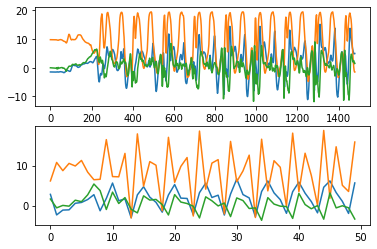

In [15]:
ex = pd.read_csv(data_dir+'JOG_47_1_annotated.csv')
length = len(ex) // 4
plt.subplot(2, 1, 1)
plt.plot(ex['acc_x'][:length])
plt.plot(ex['acc_y'][:length])
plt.plot(ex['acc_z'][:length])

plt.subplot(2, 1, 2)
plt.plot(signal.resample(ex['acc_x'][:length], 50))
plt.plot(signal.resample(ex['acc_y'][:length], 50))
plt.plot(signal.resample(ex['acc_z'][:length], 50))
plt.show()

In [16]:
for person_num in tqdm.notebook.tqdm(person_numlist):
    for adl_type in adl_types:
        for trial in trials:
            try:
                directory = data_dir + adl_type + '_' + str(person_num) + '_' + str(trial) + '_annotated.csv'
                data = pd.read_csv(directory)
                
                length = len(data) // 4
                result = pd.DataFrame(signal.resample(data['acc_x'][:length], 50))
                result.columns = ['acc_x']
                result['acc_y'] = pd.DataFrame(signal.resample(data['acc_y'][:length], 50))
                result['acc_z'] = pd.DataFrame(signal.resample(data['acc_z'][:length], 50))
                result.index = list(range(0, 50))
                
                result['label'] = 0
                
                save_route = "/workspace/inkyung/Fall Detection/Mobidata_resampled(Smartfall)/adl/" + adl_type + '_' + str(person_num) + '_' + str(trial) +'.csv'
                result.to_csv(save_route)
            except:
                print(adl_type, person_num, trial, 'no data')

STD 1 2 no data
STD 1 3 no data
WAL 1 2 no data
WAL 1 3 no data
SIT 1 2 no data
SIT 1 3 no data
LYI 1 1 no data
LYI 1 2 no data
LYI 1 3 no data
STD 2 2 no data
STD 2 3 no data
WAL 2 2 no data
WAL 2 3 no data
SIT 2 2 no data
SIT 2 3 no data
LYI 2 1 no data
LYI 2 2 no data
LYI 2 3 no data
STD 3 2 no data
STD 3 3 no data
WAL 3 2 no data
WAL 3 3 no data
SIT 3 2 no data
SIT 3 3 no data
LYI 3 1 no data
LYI 3 2 no data
LYI 3 3 no data
STD 4 2 no data
STD 4 3 no data
WAL 4 2 no data
WAL 4 3 no data
SIT 4 1 no data
SIT 4 2 no data
SIT 4 3 no data
CHU 4 1 no data
CHU 4 2 no data
CHU 4 3 no data
LYI 4 1 no data
LYI 4 2 no data
LYI 4 3 no data
STD 5 2 no data
STD 5 3 no data
WAL 5 2 no data
WAL 5 3 no data
SIT 5 2 no data
SIT 5 3 no data
LYI 5 1 no data
LYI 5 2 no data
LYI 5 3 no data
STD 6 2 no data
STD 6 3 no data
WAL 6 2 no data
WAL 6 3 no data
SIT 6 2 no data
SIT 6 3 no data
LYI 6 1 no data
LYI 6 2 no data
LYI 6 3 no data
STD 7 2 no data
STD 7 3 no data
WAL 7 2 no data
WAL 7 3 no data
SIT 7 1 

STD 32 2 no data
STD 32 3 no data
WAL 32 2 no data
WAL 32 3 no data
SIT 32 1 no data
SIT 32 2 no data
SIT 32 3 no data
CHU 32 1 no data
CHU 32 2 no data
CHU 32 3 no data
LYI 32 1 no data
LYI 32 2 no data
LYI 32 3 no data
STD 33 2 no data
STD 33 3 no data
WAL 33 2 no data
WAL 33 3 no data
SIT 33 1 no data
SIT 33 2 no data
SIT 33 3 no data
CHU 33 1 no data
CHU 33 2 no data
CHU 33 3 no data
LYI 33 1 no data
LYI 33 2 no data
LYI 33 3 no data
STD 34 2 no data
STD 34 3 no data
WAL 34 2 no data
WAL 34 3 no data
SIT 34 1 no data
SIT 34 2 no data
SIT 34 3 no data
CHU 34 1 no data
CHU 34 2 no data
CHU 34 3 no data
LYI 34 1 no data
LYI 34 2 no data
LYI 34 3 no data
STD 35 2 no data
STD 35 3 no data
WAL 35 2 no data
WAL 35 3 no data
SIT 35 1 no data
SIT 35 2 no data
SIT 35 3 no data
CHU 35 1 no data
CHU 35 2 no data
CHU 35 3 no data
LYI 35 1 no data
LYI 35 2 no data
LYI 35 3 no data
STD 36 2 no data
STD 36 3 no data
WAL 36 2 no data
WAL 36 3 no data
SIT 36 1 no data
SIT 36 2 no data
SIT 36 3 no da

In [17]:
result

,acc_x,acc_y,acc_z,label
0,7.452281,-0.791866,5.503120,0
1,8.097005,-2.178809,4.195165,0
2,7.921345,-1.778116,4.779021,0
3,7.988438,-2.020968,4.761098,0
4,7.907056,-1.842788,5.099044,0
5,7.933981,-1.979970,5.192434,0
6,7.875045,-1.864999,5.467952,0
7,7.888560,-1.960169,5.585264,0
8,7.850943,-1.882242,5.673036,0
9,7.867688,-1.959792,5.650867,0
